In [1]:
# Import default
import numpy as np
import scipy as sp
from scipy import linalg
from sklearn.base import clone
from sklearn.datasets import make_sparse_spd_matrix
from matplotlib import pyplot as plt
import seaborn as sns
plt.ion()

# skggm
import inverse_covariance as ic
from inverse_covariance import (
    QuicGraphLasso,
    QuicGraphLassoCV,
    QuicGraphLassoEBIC,
    AdaptiveGraphLasso,
    ModelAverage
)


<string>:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


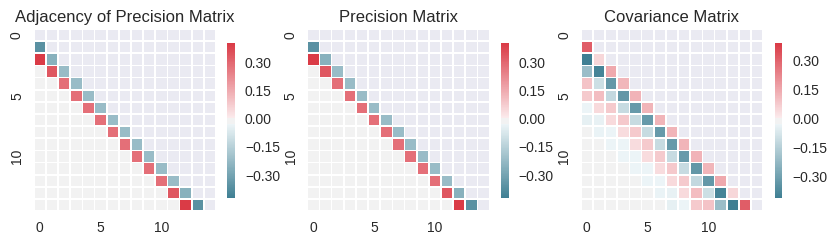

In [62]:
%run "examples/simulate_networks.py"

n_features = 15
covariance, precision, adjacency = new_graph(15,.15,adj_type='banded',random_sign=True,seed=1)    
#covariance, precision, adjacency = _new_graph(15,.3,adj_type='cluster',random_sign=False)    

# Set up the matplotlib figure
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(10, 4));

mask = np.zeros_like(precision, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
mask[np.where(np.eye(np.shape(precision)[0]))] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
adj_vmax = np.max(np.triu(adjacency,1))
sns.heatmap(adjacency,mask=mask,cmap=cmap, vmax=adj_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax1)
ax1.set_title('Adjacency of Precision Matrix')

prec_vmax = np.max(np.triu(precision,1))
sns.heatmap(precision,mask=mask,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax2)
ax2.set_title('Precision Matrix')

cov_vmax = np.max(np.triu(covariance,1))
sns.heatmap(covariance, mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax3)
ax3.set_title('Covariance Matrix')
# print "Check diagonals for precision and covariance"
# print [np.diag(precision), np.diag(covariance)]
# print "Check off diagonal maximum values"
# print np.round([adj_vmax, prec_vmax, cov_vmax],3)

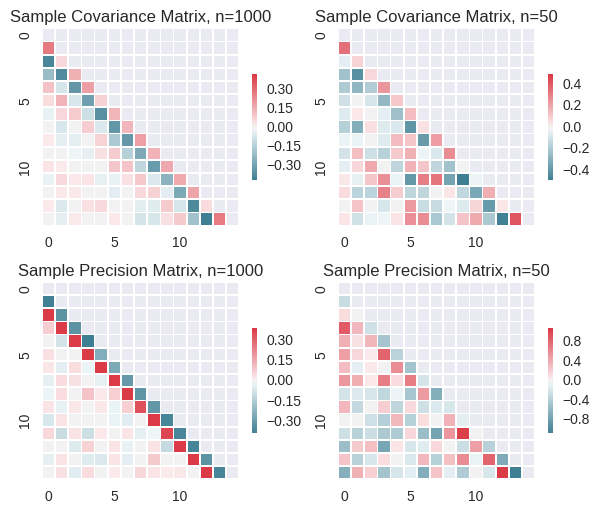

In [13]:
prng = np.random.RandomState(2)
X1 = mvn(1000,n_features,covariance,random_state=prng)
X2 = mvn(50,n_features,covariance,random_state=prng)

f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2,2,figsize=(7,6));
cov_vmax = np.max(np.triu(covariance,1))
sns.heatmap(np.tril(np.cov(X1,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Sample Covariance Matrix, n=1000')
sns.heatmap(np.tril(np.cov(X2,rowvar=False),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Sample Covariance Matrix, n=50')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X1,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('Sample Precision Matrix, n=1000')
sns.heatmap(np.tril(sp.linalg.pinv(np.cov(X2,rowvar=False)),-1),mask=mask,cmap=cmap, vmax=cov_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax4)
ax4.set_title('Sample Precision Matrix, n=50')

### Initial vs. Adaptive, High Sample Size

Difference in sparsity: 69,155
Frob Norm: 0.564946276754, Support Error: 43.0, False Pos: 43.0, False Neg: 0.0
0.783583101541
Difference in sparsity: 69,79
Frob Norm: 0.69593971411, Support Error: 5.0, False Pos: 5.0, False Neg: 0.0
0.732711887752


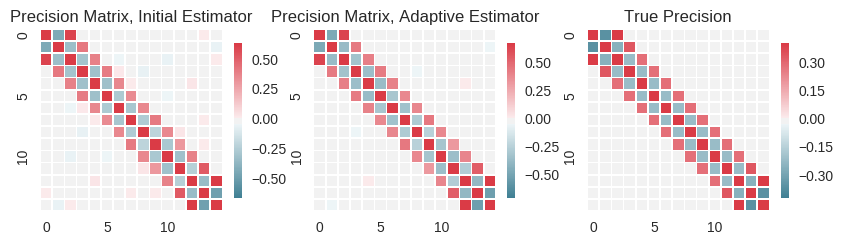

In [67]:
%run "examples/simulate_networks.py"
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

n_samples = 100*n_features
#prng = np.random.RandomState(2)

# Initial Estimator
X = mvn(n_samples,n_features,covariance,random_state=prng)
initial_estimator = QuicGraphLassoCV(init_method='corrcoef')
initial_estimator.fit(X)
prec_hat = initial_estimator.precision_
prec_vmax = np.max(np.triu(prec_hat,1))
sns.heatmap(initial_estimator.precision_,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Precision Matrix, Initial Estimator')
# Check Average Power
err_frob, err_supp, err_fp, err_fn, err_inf =  ae_trial(
    trial_estimator=initial_estimator,
    n_samples=n_samples, 
    n_features=n_features, 
    cov=covariance, 
    adj=adjacency, 
    random_state=np.random.RandomState(2),X=X)
print 'Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(initial_estimator.precision_,0))
)
print 'Frob Norm: {}, Support Error: {}, False Pos: {}, False Neg: {}'.format(
    err_frob,
    err_supp,
    err_fp,
    err_fn
)
print err_inf    
# Adaptive Estimator
twostage = AdaptiveGraphLasso(estimator=initial_estimator,method='inverse')
twostage.fit(X)
weighted_estimator = twostage.estimator_

prec_hat = weighted_estimator.precision_
prec_vmax = np.max(np.triu(prec_hat,1))
sns.heatmap(weighted_estimator.precision_,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Precision Matrix, Adaptive Estimator')
print 'Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(weighted_estimator.precision_,0))
)
# Check Average Power
err_frob, err_supp, err_fp, err_fn, err_inf =  ae_trial(
    trial_estimator=weighted_estimator,
    n_samples=n_samples, 
    n_features=n_features, 
    cov=covariance, 
    adj=adjacency, 
    random_state=np.random.RandomState(2), X = X)
print 'Frob Norm: {}, Support Error: {}, False Pos: {}, False Neg: {}'.format(
    err_frob,
    err_supp,
    err_fp,
    err_fn
)
print err_inf
prec_vmax = np.max(np.triu(precision,1))
sns.heatmap(adjacency,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('True Precision')
# Verification
# print 'Exact Recovery(T/F): {},  (TPR,FPR): {},  Count Diff: {}'.format(
#     exact_support(adjacency,precision),
#     approx_support(adjacency,precision,prob=0.1)[1:2],
#     count_support_diff(adjacency,precision),
# )


### Initial vs. Adaptive, Low Sample Size

Difference in sparsity: 69,151
Frob Norm: 0.739405685547, Support Error: 41.0, False Pos: 41.0, False Neg: 0.0
2.94565427679
Difference in sparsity: 69,125
Frob Norm: 1.06085560993, Support Error: 28.0, False Pos: 28.0, False Neg: 0.0
3.99188785666


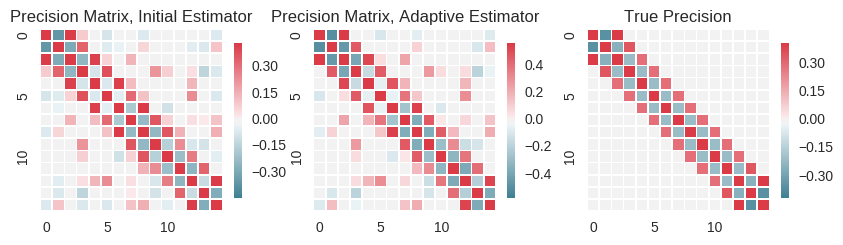

In [59]:
f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,4));

n_samples = 10*n_features
prng = np.random.RandomState(2)

# Initial Estimator
X = mvn(n_samples,n_features,covariance,random_state=prng)
initial_estimator = QuicGraphLassoCV(init_method='corrcoef')
initial_estimator.fit(X)
prec_hat = initial_estimator.precision_
prec_vmax = np.max(np.triu(prec_hat,1))
sns.heatmap(initial_estimator.precision_,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax1)
ax1.set_title('Precision Matrix, Initial Estimator')
# Check Average Power
err_frob, err_supp, err_fp, err_fn, _ =  ae_trial(
    trial_estimator=initial_estimator,
    n_samples=n_samples, 
    n_features=n_features, 
    cov=covariance, 
    adj=adjacency, 
    random_state=np.random.RandomState(2),X=X)
print 'Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(initial_estimator.precision_,0))
)
print 'Frob Norm: {}, Support Error: {}, False Pos: {}, False Neg: {}'.format(
    err_frob,
    err_supp,
    err_fp,
    err_fn
)
    
# Adaptive Estimator
twostage = AdaptiveGraphLasso(estimator=initial_estimator,method='inverse')
twostage.fit(X)
weighted_estimator = twostage.estimator_

prec_hat = weighted_estimator.precision_
prec_vmax = np.max(np.triu(prec_hat,1))
sns.heatmap(weighted_estimator.precision_,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax2)
ax2.set_title('Precision Matrix, Adaptive Estimator')
print 'Difference in sparsity: {},{}'.format(
    np.sum(np.not_equal(precision,0)), 
    np.sum(np.not_equal(weighted_estimator.precision_,0))
)
# Check Average Power
err_frob, err_supp, err_fp, err_fn, _ =  ae_trial(
    trial_estimator=weighted_estimator,
    n_samples=n_samples, 
    n_features=n_features, 
    cov=covariance, 
    adj=adjacency, 
    random_state=np.random.RandomState(2), X = X)
print 'Frob Norm: {}, Support Error: {}, False Pos: {}, False Neg: {}'.format(
    err_frob,
    err_supp,
    err_fp,
    err_fn
)
prec_vmax = np.max(np.triu(precision,1))
sns.heatmap(adjacency,cmap=cmap, vmax=prec_vmax,
            square=True, xticklabels=5, yticklabels=5,
            linewidths=.5, cbar_kws={"shrink": .5},ax=ax3)
ax3.set_title('True Precision')

NameError: name 'ae_trial' is not defined